In [1]:
#pip install pmdarima

In [2]:
%matplotlib inline
import pandas as pd 
import matplotlib 
import matplotlib.pyplot as plt
import datetime
import numpy as np
from datetime import datetime, timedelta


from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm

from sklearn.preprocessing import StandardScaler
from pmdarima.arima.utils import ndiffs
from pmdarima import auto_arima


In [3]:
# Database related all the code is moved to this file
%run -i "SqlConn.py"
#importing local py file
import SqlConn 

In [4]:
#Fetch only Finance Data
try:
    df_dbFinanceData = SqlConn.fetchFinanceData("doge")
    print("Data transfer Done")
except BaseException as err:
    print(err)


Data transfer Done


In [5]:
df_dbFinanceData["date"] = pd.to_datetime(df_dbFinanceData["date"])
df_dbFinanceData.set_index("date", inplace=True)
df_dbFinanceData

,financeType,open,high,low,close,adjustedClose,volume,id
date,,,,,,,,
2017-11-09,doge,0.001207,0.001415,0.001181,0.001415,0.001415,6259550,5214
2017-11-10,doge,0.001421,0.001431,0.001125,0.001163,0.001163,4246520,5215
2017-11-11,doge,0.001146,0.001257,0.001141,0.001201,0.001201,2231080,5216
2017-11-12,doge,0.001189,0.001210,0.001002,0.001038,0.001038,3288960,5217
2017-11-13,doge,0.001046,0.001212,0.001019,0.001211,0.001211,2481270,5218
...,...,...,...,...,...,...,...,...
2022-07-09,doge,0.069224,0.070009,0.068995,0.069512,0.069512,254272147,6917
2022-07-10,doge,0.069509,0.069509,0.066533,0.067263,0.067263,299810124,6918
2022-07-11,doge,0.067268,0.067268,0.061535,0.061847,0.061847,326125900,6919


In [6]:
df_dbFinanceData.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1708 entries, 2017-11-09 to 2022-07-13
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   financeType    1708 non-null   object 
 1   open           1708 non-null   float64
 2   high           1708 non-null   float64
 3   low            1708 non-null   float64
 4   close          1708 non-null   float64
 5   adjustedClose  1708 non-null   float64
 6   volume         1708 non-null   int64  
 7   id             1708 non-null   int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 120.1+ KB


<AxesSubplot:xlabel='date'>

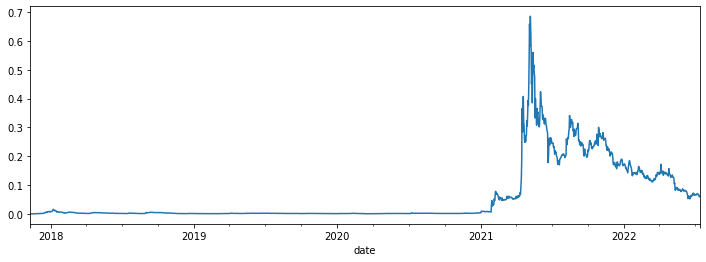

In [7]:
df_dbFinanceData['adjustedClose'].plot(figsize=(12,4))

In [8]:
df_dbFinanceData.index

DatetimeIndex(['2017-11-09', '2017-11-10', '2017-11-11', '2017-11-12',
               '2017-11-13', '2017-11-14', '2017-11-15', '2017-11-16',
               '2017-11-17', '2017-11-18',
               ...
               '2022-07-04', '2022-07-05', '2022-07-06', '2022-07-07',
               '2022-07-08', '2022-07-09', '2022-07-10', '2022-07-11',
               '2022-07-12', '2022-07-13'],
              dtype='datetime64[ns]', name='date', length=1708, freq=None)

<AxesSubplot:xlabel='date'>

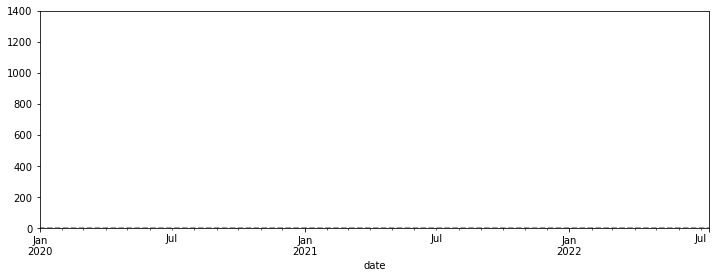

In [9]:
df_dbFinanceData['adjustedClose'].plot(xlim=['2020-01-01','2022-07-13'],ylim=[0,1400],figsize=(12,4),ls='--',c='green')

<AxesSubplot:xlabel='date'>

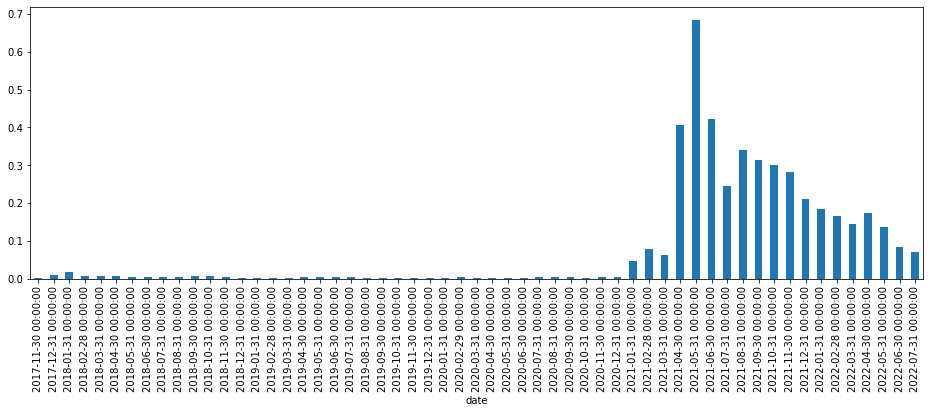

In [10]:
#Resampling to display monthly data
df_resampled = df_dbFinanceData['adjustedClose'].resample(rule='M')
df_resampled.max().plot(kind='bar',figsize=(16,5))

In [11]:
df_filteredData = df_dbFinanceData.loc['2020-01-01':'2022-7-13']
df_filteredData.index

DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
               '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10',
               ...
               '2022-07-04', '2022-07-05', '2022-07-06', '2022-07-07',
               '2022-07-08', '2022-07-09', '2022-07-10', '2022-07-11',
               '2022-07-12', '2022-07-13'],
              dtype='datetime64[ns]', name='date', length=925, freq=None)

<AxesSubplot:xlabel='date'>

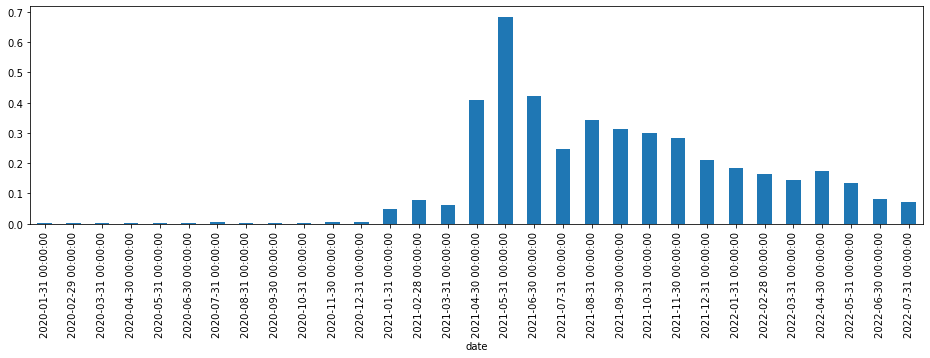

In [12]:
#Nov 2021 was the month when Tesla had highest value - checked over internet and found Nov 4 2021 was marked as highest price for Tesla stocks.
df_filteredData['adjustedClose'].resample(rule='M').max().plot(kind='bar', figsize=(16,4))

<AxesSubplot:xlabel='date'>

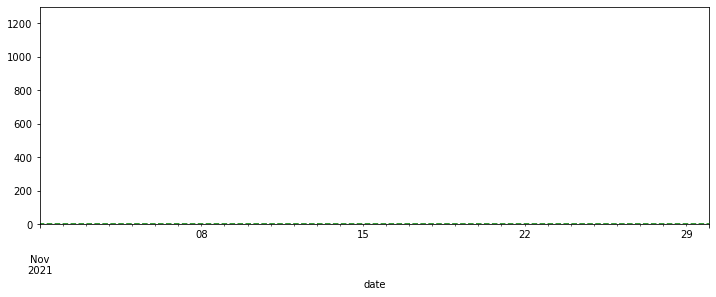

In [13]:
df_filteredData['adjustedClose'].plot(xlim=['2021-11-01','2021-11-30'],ylim=[0,1300],figsize=(12,4),ls='--',c='green')


<AxesSubplot:xlabel='date'>

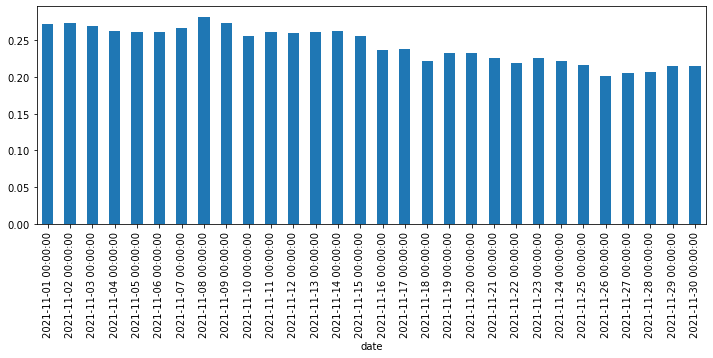

In [14]:
# checked over internet and found Nov 4 2021 was marked as highest price for Tesla stocks.
df_filteredData.loc['2021-11-01':'2021-11-30']['adjustedClose'].plot(kind='bar',figsize=(12,4))

In [15]:
#5 and 15 days rolling mean
df_dbFinanceData["adjustedClose:5 Days Rolling mean"]=df_dbFinanceData['adjustedClose'].rolling(5).mean() 
df_dbFinanceData["adjustedClose:15 Days Rolling mean"]=df_dbFinanceData['adjustedClose'].rolling(15).mean() 
df_dbFinanceData["adjustedClose:60 Days Rolling mean"]=df_dbFinanceData['adjustedClose'].rolling(60).mean() 
df_dbFinanceData

,financeType,open,high,low,close,adjustedClose,volume,id,adjustedClose:5 Days Rolling mean,adjustedClose:15 Days Rolling mean,adjustedClose:60 Days Rolling mean
date,,,,,,,,,,,
2017-11-09,doge,0.001207,0.001415,0.001181,0.001415,0.001415,6259550,5214,NaN,NaN,NaN
2017-11-10,doge,0.001421,0.001431,0.001125,0.001163,0.001163,4246520,5215,NaN,NaN,NaN
2017-11-11,doge,0.001146,0.001257,0.001141,0.001201,0.001201,2231080,5216,NaN,NaN,NaN
2017-11-12,doge,0.001189,0.001210,0.001002,0.001038,0.001038,3288960,5217,NaN,NaN,NaN
2017-11-13,doge,0.001046,0.001212,0.001019,0.001211,0.001211,2481270,5218,0.001206,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2022-07-09,doge,0.069224,0.070009,0.068995,0.069512,0.069512,254272147,6917,0.069026,0.068672,0.074572
2022-07-10,doge,0.069509,0.069509,0.066533,0.067263,0.067263,299810124,6918,0.069047,0.068589,0.074284
2022-07-11,doge,0.067268,0.067268,0.061535,0.061847,0.061847,326125900,6919,0.067700,0.067834,0.073937


<AxesSubplot:xlabel='date'>

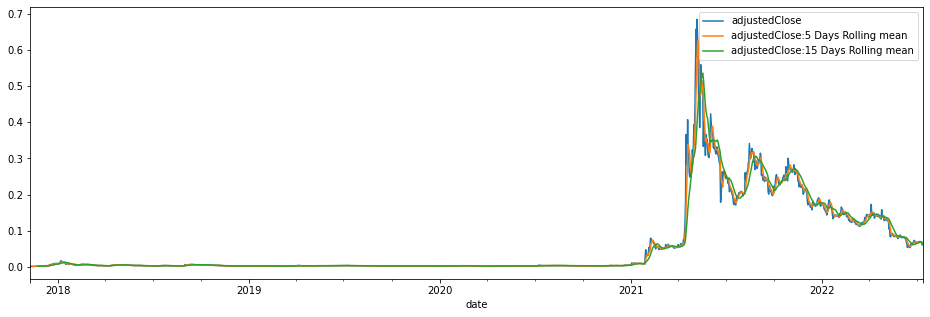

In [16]:
#smoothening the line
df_dbFinanceData[['adjustedClose','adjustedClose:5 Days Rolling mean','adjustedClose:15 Days Rolling mean']].plot(figsize=(16,5))

<AxesSubplot:xlabel='date'>

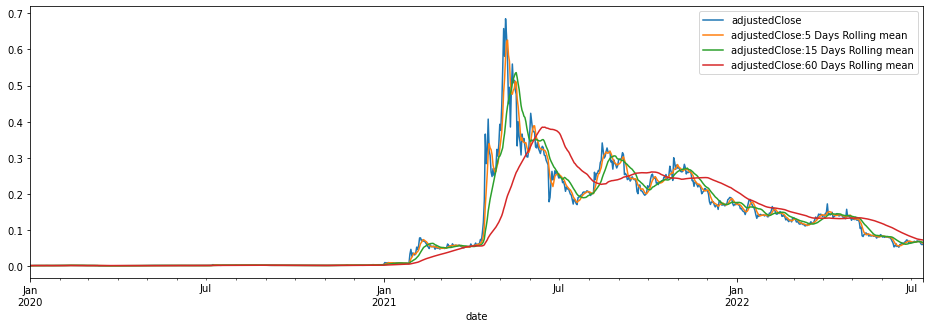

In [17]:
#smoothening the line
df_dbFinanceData.loc['2020-01-01':'2022-7-13'][['adjustedClose','adjustedClose:5 Days Rolling mean','adjustedClose:15 Days Rolling mean','adjustedClose:60 Days Rolling mean']].plot(figsize=(16,5))

#rolling mean of 5 days is closer compared to 15 days

<AxesSubplot:xlabel='date'>

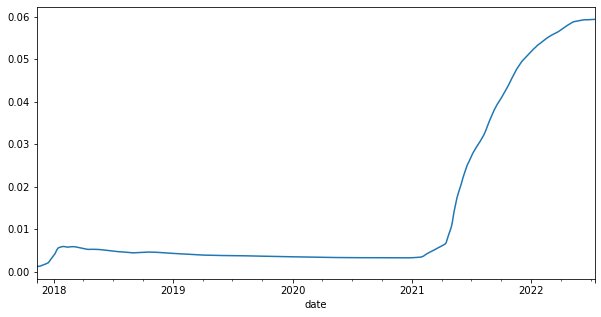

In [18]:
#Cummulative moving average
df_dbFinanceData['adjustedClose'].expanding().mean().plot(figsize=(10,5))

In [19]:
#exponential weighted moving average
df_dbFinanceData['emw0.2']=df_dbFinanceData['adjustedClose'].ewm(alpha=0.2,adjust=False).mean()
df_dbFinanceData['emw0.4']=df_dbFinanceData['adjustedClose'].ewm(alpha=0.4,adjust=False).mean()
df_dbFinanceData['emw_span5']=df_dbFinanceData['adjustedClose'].ewm(span=2,).mean()

<AxesSubplot:xlabel='date'>

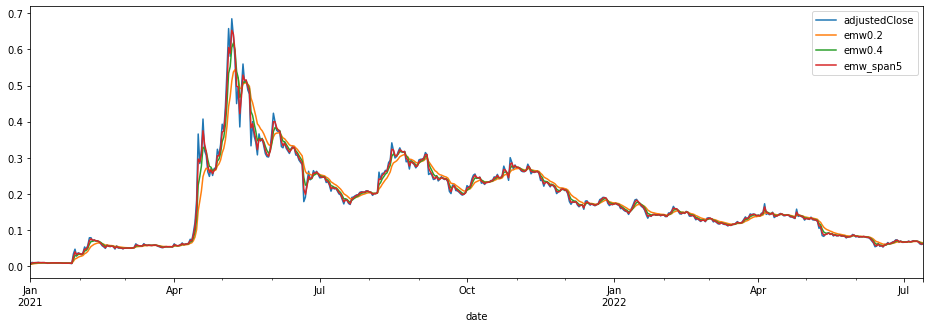

In [20]:
df_dbFinanceData[['adjustedClose','emw0.2','emw0.4','emw_span5']].plot(xlim=['2021-01-01','2022-7-13'],figsize=(16,5))

<AxesSubplot:xlabel='date'>

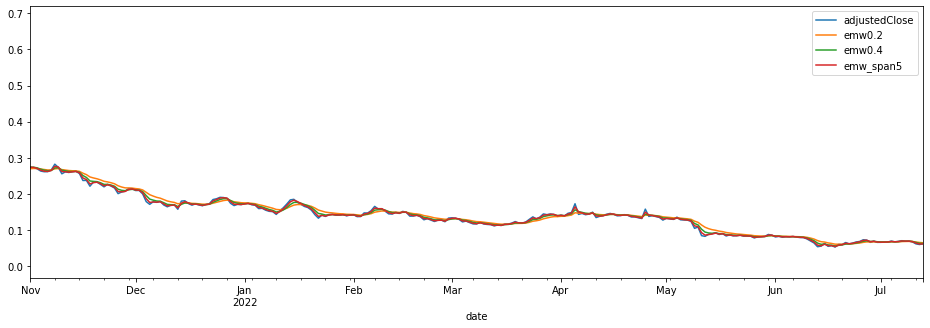

In [21]:
df_dbFinanceData[['adjustedClose','emw0.2','emw0.4','emw_span5']].plot(xlim=['2021-11-01','2022-7-13'],figsize=(16,5))

# Applying ARIMA Model

In [22]:
#Augmented Dickey–Fuller test
def adf_test(series):
    results = adfuller(series)
    print('ADF statistics: {}'.format(results[0]))
    print('P value: {}'.format(results[1]))
    if results[1] < 0.05:
        print("Ho Rejected - data is stationary")
    else:    
        print("Ho Accepted- data is not stationary")

In [23]:
adf_test(df_dbFinanceData['adjustedClose'])

ADF statistics: -2.4187282724682433
P value: 0.13652010989240332
Ho Accepted- data is not stationary


In [24]:
df_dbFinanceData['adjustedClose_first_diff']=df_dbFinanceData['adjustedClose']-df_dbFinanceData['adjustedClose'].shift(1)

In [25]:
adf_test(df_dbFinanceData['adjustedClose_first_diff'].dropna())
#d=1

ADF statistics: -8.262922943789258
P value: 5.026682072867797e-13
Ho Rejected - data is stationary


In [26]:
df_dbFinanceData

,financeType,open,high,low,close,adjustedClose,volume,id,adjustedClose:5 Days Rolling mean,adjustedClose:15 Days Rolling mean,adjustedClose:60 Days Rolling mean,emw0.2,emw0.4,emw_span5,adjustedClose_first_diff
date,,,,,,,,,,,,,,,
2017-11-09,doge,0.001207,0.001415,0.001181,0.001415,0.001415,6259550,5214,NaN,NaN,NaN,0.001415,0.001415,0.001415,NaN
2017-11-10,doge,0.001421,0.001431,0.001125,0.001163,0.001163,4246520,5215,NaN,NaN,NaN,0.001365,0.001314,0.001226,-0.000252
2017-11-11,doge,0.001146,0.001257,0.001141,0.001201,0.001201,2231080,5216,NaN,NaN,NaN,0.001332,0.001269,0.001209,0.000038
2017-11-12,doge,0.001189,0.001210,0.001002,0.001038,0.001038,3288960,5217,NaN,NaN,NaN,0.001273,0.001177,0.001093,-0.000163
2017-11-13,doge,0.001046,0.001212,0.001019,0.001211,0.001211,2481270,5218,0.001206,NaN,NaN,0.001261,0.001190,0.001172,0.000173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-09,doge,0.069224,0.070009,0.068995,0.069512,0.069512,254272147,6917,0.069026,0.068672,0.074572,0.068662,0.069292,0.069492,0.000255
2022-07-10,doge,0.069509,0.069509,0.066533,0.067263,0.067263,299810124,6918,0.069047,0.068589,0.074284,0.068382,0.068480,0.068006,-0.002249
2022-07-11,doge,0.067268,0.067268,0.061535,0.061847,0.061847,326125900,6919,0.067700,0.067834,0.073937,0.067075,0.065827,0.063900,-0.005416


# Calculate AR(p), I(d), MA(q) 

In [27]:
#Estimate ARIMA differencing term,
ndiffs(df_dbFinanceData['adjustedClose'],test='adf')

1

C:\Users\15125\anaconda3\envs\PythonData\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


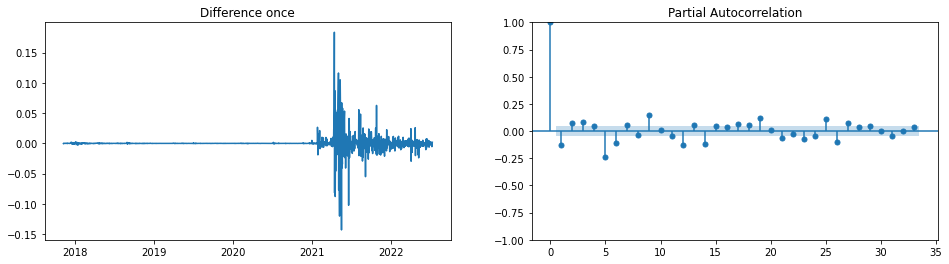

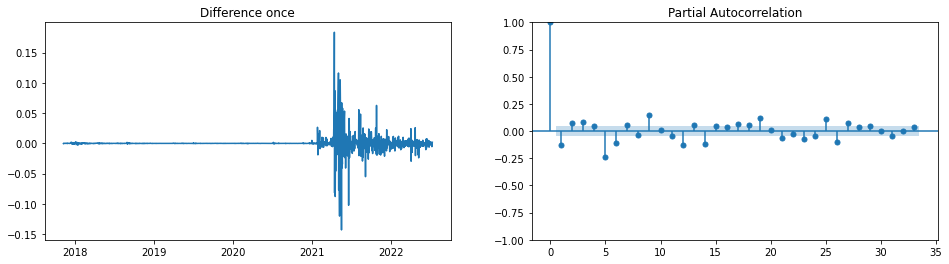

In [28]:
diff= df_dbFinanceData['adjustedClose'].diff().dropna()
fig,(ax1,ax2)=plt.subplots(1, 2, figsize=(16,4))
ax1.plot(diff)
ax1.set_title("Difference once")
ax2.set_ylim(0, 1)
plot_pacf(diff, ax=ax2)
#p=2

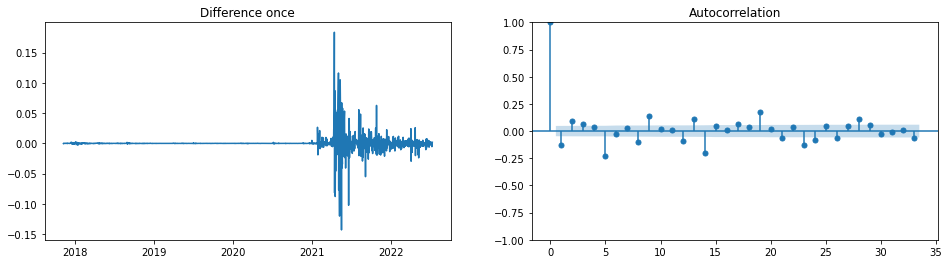

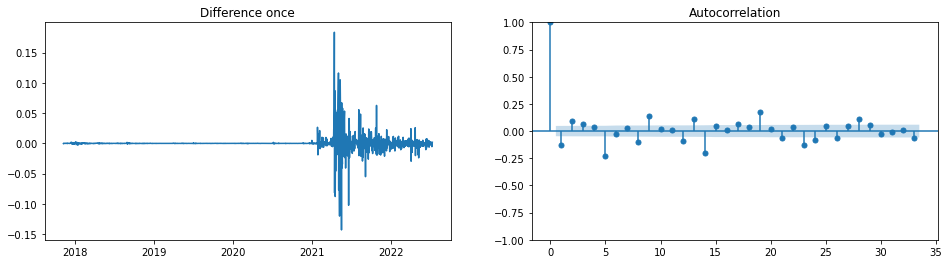

In [29]:
diff= df_dbFinanceData['adjustedClose'].diff().dropna()
fig,(ax1,ax2)=plt.subplots(1, 2, figsize=(16,4))
ax1.plot(diff)
ax1.set_title("Difference once")
ax2.set_ylim(0, 1)
plot_acf(diff, ax=ax2)
#q=2

#Other ways to find P and Q

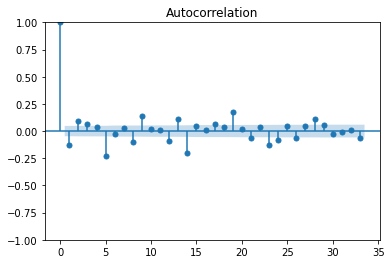

In [30]:
acf = plot_acf(df_dbFinanceData['adjustedClose_first_diff'].dropna())
#q=2

C:\Users\15125\anaconda3\envs\PythonData\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


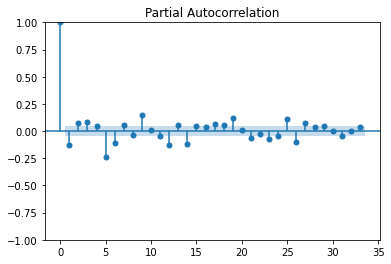

In [31]:
acf = plot_pacf(df_dbFinanceData['adjustedClose_first_diff'].dropna())
#p=2

third way to find p,d,q- using Auto_arima

In [32]:
stepwise_fit = auto_arima(df_dbFinanceData['adjustedClose'],trace=True,suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-10143.691, Time=3.02 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-10089.563, Time=0.57 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-10116.741, Time=0.55 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-10111.709, Time=0.34 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-10091.550, Time=0.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-10142.024, Time=2.65 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-10123.208, Time=1.99 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-10180.729, Time=4.55 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-10132.767, Time=1.06 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-10176.249, Time=5.24 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-10205.297, Time=3.92 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-10185.604, Time=2.71 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=-10201.692, Time=4.33 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=-10206.622, Time=4.50 sec
 ARIM

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1708
Model:               SARIMAX(5, 1, 4)   Log Likelihood                5168.234
Date:                Tue, 26 Jul 2022   AIC                         -10316.467
Time:                        17:51:03   BIC                         -10262.042
Sample:                             0   HQIC                        -10296.323
                               - 1708                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1968      0.019     10.286      0.000       0.159       0.234
ar.L2         -0.3223      0.021    -15.306      0.000      -0.364      -0.281
ar.L3          0.2725      0.018     15.539      0.000       0.238       0.307
ar.L4         -0.4879      0.014    -35.497      0.000      -0.515      -0.461
ar.L5         -0.2891      0.006    -48.186      0.000      -0.301      -0.277
ma.L1         -0.3339      0.020    -16.321      0.000      -0.374      -0.294
ma.L2          0.4672      0.024     19.725      0.000       0.421       0.514
ma.L3         -0.2544      0.020    -12.753      0.000      -0.294      -0.215
ma.L4          0.5833      0.016     36.296      0.000       0.552       0.615
sigma2         0.0001    9.5e-07    144.158      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):            337692.06
Prob(Q):                              0.70   Prob(JB):                         0.00
Heteroskedasticity (H):            1713.51   Skew:                             2.80
Prob(H) (two-sided):                  0.00   Kurtosis:                        71.68
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Fitting the Model and Predicting

In [33]:
df_arima = df_dbFinanceData.copy()
df_arima.drop(columns=['financeType'],inplace=True)
train_dataset_end=datetime(2021,7,31)
test_dataset_end=datetime(2022,7,31)

In [34]:
train_data=df_arima[:train_dataset_end]
test_data=df_arima[train_dataset_end+timedelta(days=1):test_dataset_end]

In [35]:
##prediction
pred_start_date=test_data.index[0]
pred_end_date=test_data.index[-1]

In [36]:
train_data

,open,high,low,close,adjustedClose,volume,id,adjustedClose:5 Days Rolling mean,adjustedClose:15 Days Rolling mean,adjustedClose:60 Days Rolling mean,emw0.2,emw0.4,emw_span5,adjustedClose_first_diff
date,,,,,,,,,,,,,,
2017-11-09,0.001207,0.001415,0.001181,0.001415,0.001415,6259550,5214,NaN,NaN,NaN,0.001415,0.001415,0.001415,NaN
2017-11-10,0.001421,0.001431,0.001125,0.001163,0.001163,4246520,5215,NaN,NaN,NaN,0.001365,0.001314,0.001226,-0.000252
2017-11-11,0.001146,0.001257,0.001141,0.001201,0.001201,2231080,5216,NaN,NaN,NaN,0.001332,0.001269,0.001209,0.000038
2017-11-12,0.001189,0.001210,0.001002,0.001038,0.001038,3288960,5217,NaN,NaN,NaN,0.001273,0.001177,0.001093,-0.000163
2017-11-13,0.001046,0.001212,0.001019,0.001211,0.001211,2481270,5218,0.001206,NaN,NaN,0.001261,0.001190,0.001172,0.000173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-27,0.203836,0.209293,0.195350,0.205899,0.205899,2229903212,6570,0.200053,0.189946,0.260664,0.196998,0.201501,0.204602,0.001480
2021-07-28,0.206111,0.213746,0.202011,0.205392,0.205392,2076707890,6571,0.202179,0.190305,0.259035,0.198677,0.203057,0.205129,-0.000507
2021-07-29,0.205591,0.206355,0.200716,0.204619,0.204619,1169322798,6572,0.203639,0.190792,0.257408,0.199865,0.203682,0.204789,-0.000773


In [37]:
test_data

,open,high,low,close,adjustedClose,volume,id,adjustedClose:5 Days Rolling mean,adjustedClose:15 Days Rolling mean,adjustedClose:60 Days Rolling mean,emw0.2,emw0.4,emw_span5,adjustedClose_first_diff
date,,,,,,,,,,,,,,
2021-08-01,0.207753,0.217611,0.201389,0.204437,0.204437,1711494501,6575,0.206317,0.196006,0.249113,0.203278,0.205836,0.205636,-0.003877
2021-08-02,0.204279,0.209959,0.202188,0.203600,0.203600,1181469976,6576,0.205958,0.197430,0.245841,0.203342,0.204941,0.204279,-0.000837
2021-08-03,0.203431,0.205077,0.193750,0.195967,0.195967,1121632377,6577,0.204228,0.198925,0.242835,0.201867,0.201352,0.198738,-0.007633
2021-08-04,0.196312,0.203110,0.194450,0.201490,0.201490,1095300718,6578,0.202762,0.200970,0.239990,0.201792,0.201407,0.200573,0.005523
2021-08-05,0.201575,0.202513,0.194685,0.200974,0.200974,1139204754,6579,0.201294,0.201679,0.237143,0.201628,0.201234,0.200840,-0.000516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-09,0.069224,0.070009,0.068995,0.069512,0.069512,254272147,6917,0.069026,0.068672,0.074572,0.068662,0.069292,0.069492,0.000255
2022-07-10,0.069509,0.069509,0.066533,0.067263,0.067263,299810124,6918,0.069047,0.068589,0.074284,0.068382,0.068480,0.068006,-0.002249
2022-07-11,0.067268,0.067268,0.061535,0.061847,0.061847,326125900,6919,0.067700,0.067834,0.073937,0.067075,0.065827,0.063900,-0.005416


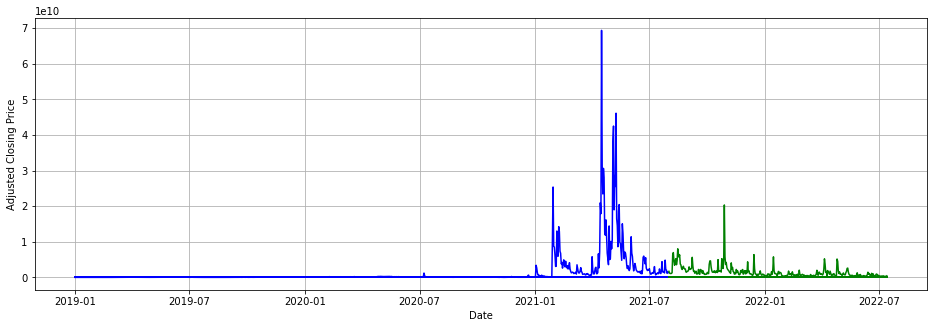

In [38]:
startdate=datetime(2019,1,1)
plt.figure(figsize=(16,5))
plt.grid(True)
plt.xlabel("Date")
plt.ylabel("Adjusted Closing Price")
plt.plot(train_data[startdate:],'blue', label="training data")
plt.plot(test_data, 'green' , label="testing data")
#plt.legend(loc="upper left")

# Train the ARIMA Model

In [39]:
model_ARIMA=sm.tsa.arima.ARIMA(train_data['adjustedClose'],order=(2,1,2))

C:\Users\15125\anaconda3\envs\PythonData\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\15125\anaconda3\envs\PythonData\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\15125\anaconda3\envs\PythonData\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [40]:
model_ARIMA_fit = model_ARIMA.fit()

C:\Users\15125\anaconda3\envs\PythonData\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\15125\anaconda3\envs\PythonData\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\15125\anaconda3\envs\PythonData\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [41]:
model_ARIMA_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          adjustedClose   No. Observations:                 1361
Model:                 ARIMA(2, 1, 2)   Log Likelihood                4032.691
Date:                Tue, 26 Jul 2022   AIC                          -8055.382
Time:                        17:51:05   BIC                          -8029.306
Sample:                    11-09-2017   HQIC                         -8045.620
                         - 07-31-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5637      0.015     37.249      0.000       0.534       0.593
ar.L2         -0.5151      0.016    -31.719      0.000      -0.547      -0.483
ma.L1         -0.7112      0.014    -52.613      0.000      -0.738      -0.685
ma.L2          0.7937      0.013     60.402      0.000       0.768       0.819
sigma2         0.0002   1.12e-06    138.381      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):            281720.43
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):            1555.51   Skew:                             2.48
Prob(H) (two-sided):                  0.00   Kurtosis:                        73.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:ylabel='Density'>

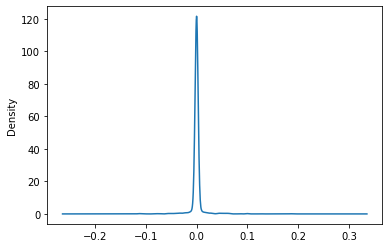

In [42]:
model_ARIMA_fit.resid.plot(kind='kde')

(array([7.35252215e-02, 1.47050443e-01, 3.43117700e-01, 3.14687948e+01,
        8.82302658e-01, 2.94100886e-01, 4.90168143e-02, 7.35252215e-02,
        0.00000000e+00, 2.45084072e-02]),
 array([-0.11420837, -0.08422871, -0.05424904, -0.02426938,  0.00571029,
         0.03568996,  0.06566962,  0.09564929,  0.12562895,  0.15560862,
         0.18558828]),
 <BarContainer object of 10 artists>)

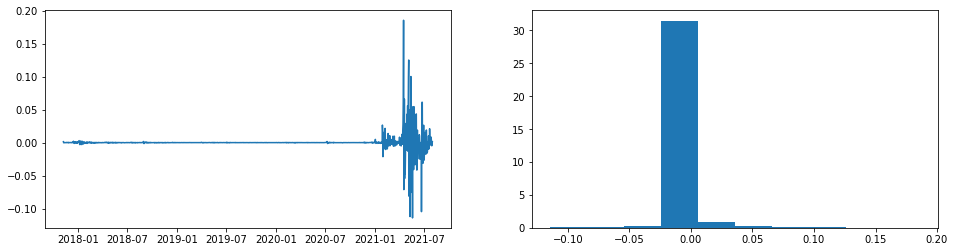

In [43]:
resids = pd.DataFrame(model_ARIMA_fit.resid)
fig, (ax1, ax2) = plt.subplots(1 ,2, figsize=(16,4))
ax1.plot(resids)
ax2.hist(resids, density=True)

In [44]:
##prediction
pred_start_date=pd.to_datetime(test_data.index[0])
pred_end_date=pd.to_datetime(test_data.index[-1])
print(pred_start_date)
print(pred_end_date)

2021-08-01 00:00:00
2022-07-13 00:00:00


In [45]:
-len(train_data)

-1361

Predicted Adjustclose Values
2021-08-01    0.205769
2021-08-02    0.205720
2021-08-03    0.207003
2021-08-04    0.207751
2021-08-05    0.207513
                ...   
2022-07-09    0.207095
2022-07-10    0.207095
2022-07-11    0.207095
2022-07-12    0.207095
2022-07-13    0.207095
Freq: D, Name: predicted_mean, Length: 347, dtype: float64


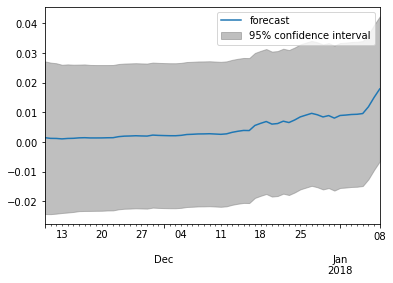

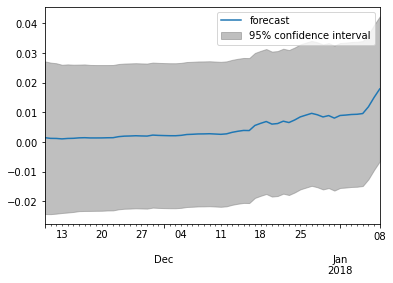

In [46]:
from statsmodels.graphics.tsaplots import plot_predict
adjustedCloseByArima_pred =model_ARIMA_fit.predict(start=len(train_data),end=(len(train_data) + len(test_data)-1)) 
adjustedCloseByArima_predictions = model_ARIMA_fit.get_prediction(start = -len(test_data))
residuals = test_data['adjustedClose']-adjustedCloseByArima_pred
print("Predicted Adjustclose Values")
print(adjustedCloseByArima_pred)
plot_predict(model_ARIMA_fit, start=1, end=60,dynamic=False)

In [47]:
df_yPred = adjustedCloseByArima_predictions.summary_frame(alpha=0.10)

# Extract prediction mean
mean_forecast = adjustedCloseByArima_predictions.predicted_mean

# Get confidence intervals of predictions
confidence_intervals = adjustedCloseByArima_predictions.conf_int()
confidence_intervals


,lower adjustedClose,upper adjustedClose
2020-08-19,-0.020913,0.027965
2020-08-20,-0.020998,0.027880
2020-08-21,-0.021008,0.027870
2020-08-22,-0.021060,0.027818
2020-08-23,-0.021010,0.027868
...,...,...
2021-07-27,0.175241,0.224119
2021-07-28,0.181259,0.230137
2021-07-29,0.185058,0.233936
2021-07-30,0.183232,0.232110


<AxesSubplot:>

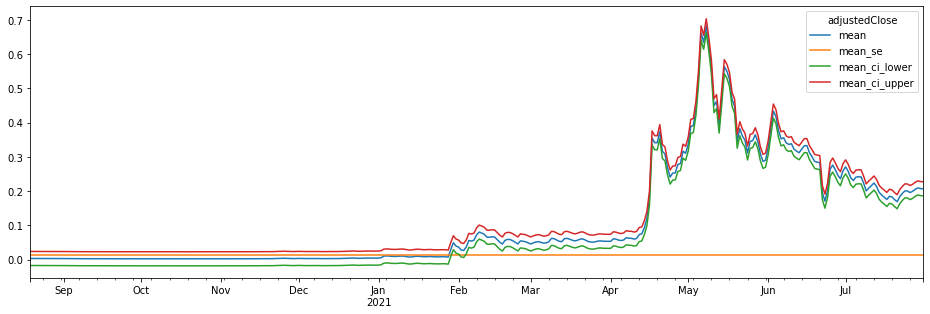

In [48]:
df_yPred.plot(figsize=(16,5))

In [49]:
d1 = pd.DataFrame(test_data['adjustedClose'])
d2 = pd.DataFrame(mean_forecast)
d2['date'] = d1.index
d2.set_index('date',inplace=True)
df_y_yPred = pd.concat([d1,d2],axis=1)

In [50]:
df_y_yPred

,adjustedClose,predicted_mean
date,,
2021-08-01,0.204437,0.003526
2021-08-02,0.203600,0.003441
2021-08-03,0.195967,0.003431
2021-08-04,0.201490,0.003379
2021-08-05,0.200974,0.003429
...,...,...
2022-07-09,0.069512,0.199680
2022-07-10,0.067263,0.205698
2022-07-11,0.061847,0.209497


<AxesSubplot:xlabel='date'>

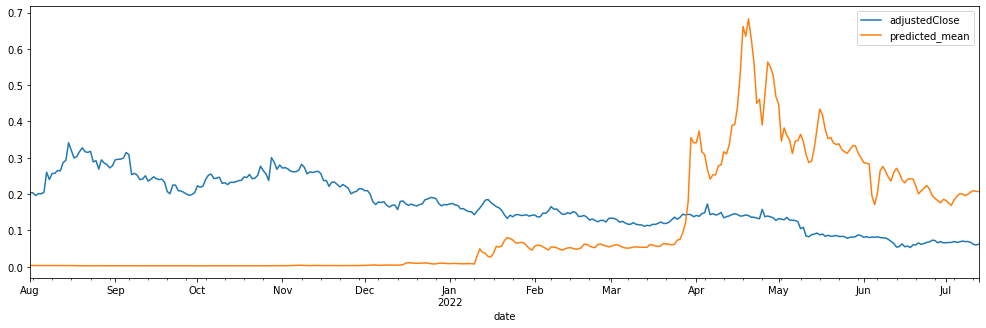

In [51]:
df_y_yPred.plot(figsize=(17,5))

# Forecasting

In [52]:
step = 30
fc = model_ARIMA_fit.forecast(step)
lst_fc = list(fc)
lst_fc

[0.2057692369670796,
 0.20571975045167784,
 0.20700276989281327,
 0.20775145066388714,
 0.20751251635763293,
 0.20699216183022287,
 0.2068219431781419,
 0.2069940537532119,
 0.20717875249096857,
 0.20719419869253175,
 0.20710775912989202,
 0.2070510795270892,
 0.20706366004370944,
 0.20709994920825062,
 0.2071139232541383,
 0.20710310582594488,
 0.20708980985085892,
 0.20708788793253619,
 0.20709365393050672,
 0.20709789405945397,
 0.20709731375051801,
 0.2070948023864945,
 0.20709368576938306,
 0.2070943500835498,
 0.20709529974745966,
 0.20709549282030873,
 0.20709511243667375,
 0.20709479856935814,
 0.20709481760594575,
 0.20709499002221302]

In [53]:
fc

2021-08-01    0.205769
2021-08-02    0.205720
2021-08-03    0.207003
2021-08-04    0.207751
2021-08-05    0.207513
2021-08-06    0.206992
2021-08-07    0.206822
2021-08-08    0.206994
2021-08-09    0.207179
2021-08-10    0.207194
2021-08-11    0.207108
2021-08-12    0.207051
2021-08-13    0.207064
2021-08-14    0.207100
2021-08-15    0.207114
2021-08-16    0.207103
2021-08-17    0.207090
2021-08-18    0.207088
2021-08-19    0.207094
2021-08-20    0.207098
2021-08-21    0.207097
2021-08-22    0.207095
2021-08-23    0.207094
2021-08-24    0.207094
2021-08-25    0.207095
2021-08-26    0.207095
2021-08-27    0.207095
2021-08-28    0.207095
2021-08-29    0.207095
2021-08-30    0.207095
Freq: D, Name: predicted_mean, dtype: float64

In [54]:
import time
import datetime
from datetime import date,timedelta


end_date = pred_end_date 

date_future = end_date + datetime.timedelta(41)

df_future_dates = pd.date_range(start=end_date, end=date_future,freq='B')
df_future_dates

DatetimeIndex(['2022-07-13', '2022-07-14', '2022-07-15', '2022-07-18',
               '2022-07-19', '2022-07-20', '2022-07-21', '2022-07-22',
               '2022-07-25', '2022-07-26', '2022-07-27', '2022-07-28',
               '2022-07-29', '2022-08-01', '2022-08-02', '2022-08-03',
               '2022-08-04', '2022-08-05', '2022-08-08', '2022-08-09',
               '2022-08-10', '2022-08-11', '2022-08-12', '2022-08-15',
               '2022-08-16', '2022-08-17', '2022-08-18', '2022-08-19',
               '2022-08-22', '2022-08-23'],
              dtype='datetime64[ns]', freq='B')

In [55]:
df_future_dates

DatetimeIndex(['2022-07-13', '2022-07-14', '2022-07-15', '2022-07-18',
               '2022-07-19', '2022-07-20', '2022-07-21', '2022-07-22',
               '2022-07-25', '2022-07-26', '2022-07-27', '2022-07-28',
               '2022-07-29', '2022-08-01', '2022-08-02', '2022-08-03',
               '2022-08-04', '2022-08-05', '2022-08-08', '2022-08-09',
               '2022-08-10', '2022-08-11', '2022-08-12', '2022-08-15',
               '2022-08-16', '2022-08-17', '2022-08-18', '2022-08-19',
               '2022-08-22', '2022-08-23'],
              dtype='datetime64[ns]', freq='B')

In [56]:
df_combine = pd.DataFrame(df_future_dates,lst_fc)
df_combine.columns=['date']
df_combine

,date
0.205769,2022-07-13
0.205720,2022-07-14
0.207003,2022-07-15
0.207751,2022-07-18
0.207513,2022-07-19
0.206992,2022-07-20
0.206822,2022-07-21
0.206994,2022-07-22
0.207179,2022-07-25
0.207194,2022-07-26


In [57]:
df_combine = df_combine.reset_index()
df_combine = df_combine.set_index('date')
df_combine

,index
date,
2022-07-13,0.205769
2022-07-14,0.205720
2022-07-15,0.207003
2022-07-18,0.207751
2022-07-19,0.207513
2022-07-20,0.206992
2022-07-21,0.206822
2022-07-22,0.206994
2022-07-25,0.207179


In [58]:
df_combine.rename(columns={"index":"forecasted_mean"},inplace=True)

In [59]:
df_combine

,forecasted_mean
date,
2022-07-13,0.205769
2022-07-14,0.205720
2022-07-15,0.207003
2022-07-18,0.207751
2022-07-19,0.207513
2022-07-20,0.206992
2022-07-21,0.206822
2022-07-22,0.206994
2022-07-25,0.207179


In [60]:
test_data

,open,high,low,close,adjustedClose,volume,id,adjustedClose:5 Days Rolling mean,adjustedClose:15 Days Rolling mean,adjustedClose:60 Days Rolling mean,emw0.2,emw0.4,emw_span5,adjustedClose_first_diff
date,,,,,,,,,,,,,,
2021-08-01,0.207753,0.217611,0.201389,0.204437,0.204437,1711494501,6575,0.206317,0.196006,0.249113,0.203278,0.205836,0.205636,-0.003877
2021-08-02,0.204279,0.209959,0.202188,0.203600,0.203600,1181469976,6576,0.205958,0.197430,0.245841,0.203342,0.204941,0.204279,-0.000837
2021-08-03,0.203431,0.205077,0.193750,0.195967,0.195967,1121632377,6577,0.204228,0.198925,0.242835,0.201867,0.201352,0.198738,-0.007633
2021-08-04,0.196312,0.203110,0.194450,0.201490,0.201490,1095300718,6578,0.202762,0.200970,0.239990,0.201792,0.201407,0.200573,0.005523
2021-08-05,0.201575,0.202513,0.194685,0.200974,0.200974,1139204754,6579,0.201294,0.201679,0.237143,0.201628,0.201234,0.200840,-0.000516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-09,0.069224,0.070009,0.068995,0.069512,0.069512,254272147,6917,0.069026,0.068672,0.074572,0.068662,0.069292,0.069492,0.000255
2022-07-10,0.069509,0.069509,0.066533,0.067263,0.067263,299810124,6918,0.069047,0.068589,0.074284,0.068382,0.068480,0.068006,-0.002249
2022-07-11,0.067268,0.067268,0.061535,0.061847,0.061847,326125900,6919,0.067700,0.067834,0.073937,0.067075,0.065827,0.063900,-0.005416


In [61]:
test_data

,open,high,low,close,adjustedClose,volume,id,adjustedClose:5 Days Rolling mean,adjustedClose:15 Days Rolling mean,adjustedClose:60 Days Rolling mean,emw0.2,emw0.4,emw_span5,adjustedClose_first_diff
date,,,,,,,,,,,,,,
2021-08-01,0.207753,0.217611,0.201389,0.204437,0.204437,1711494501,6575,0.206317,0.196006,0.249113,0.203278,0.205836,0.205636,-0.003877
2021-08-02,0.204279,0.209959,0.202188,0.203600,0.203600,1181469976,6576,0.205958,0.197430,0.245841,0.203342,0.204941,0.204279,-0.000837
2021-08-03,0.203431,0.205077,0.193750,0.195967,0.195967,1121632377,6577,0.204228,0.198925,0.242835,0.201867,0.201352,0.198738,-0.007633
2021-08-04,0.196312,0.203110,0.194450,0.201490,0.201490,1095300718,6578,0.202762,0.200970,0.239990,0.201792,0.201407,0.200573,0.005523
2021-08-05,0.201575,0.202513,0.194685,0.200974,0.200974,1139204754,6579,0.201294,0.201679,0.237143,0.201628,0.201234,0.200840,-0.000516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-07-09,0.069224,0.070009,0.068995,0.069512,0.069512,254272147,6917,0.069026,0.068672,0.074572,0.068662,0.069292,0.069492,0.000255
2022-07-10,0.069509,0.069509,0.066533,0.067263,0.067263,299810124,6918,0.069047,0.068589,0.074284,0.068382,0.068480,0.068006,-0.002249
2022-07-11,0.067268,0.067268,0.061535,0.061847,0.061847,326125900,6919,0.067700,0.067834,0.073937,0.067075,0.065827,0.063900,-0.005416


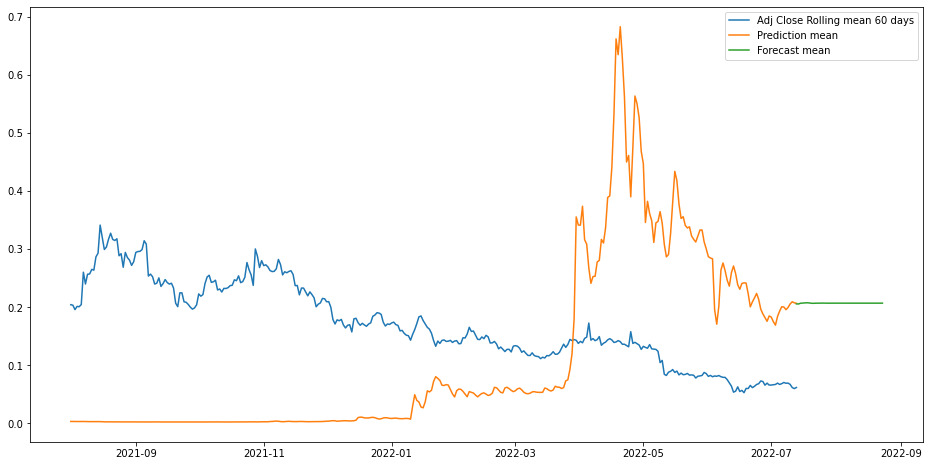

In [62]:
#plot the predictions for validation set
plt.figure(figsize=(16, 8))
plt.plot(test_data["adjustedClose"], label='Adj Close Rolling mean 60 days')
#plt.plot(valid, label='Valid')
plt.plot(df_y_yPred["predicted_mean"], label='Prediction mean')
plt.plot(df_combine["forecasted_mean"], label='Forecast mean')
plt.legend()
plt.show()

In [63]:
mape = np.mean(np.abs(np.array(fc[:1])-np.array(test_data["adjustedClose"]))/np.abs(test_data["adjustedClose"]))
print("MAPE: " + str(mape))
#MEAN ABSOLUTE PERCENTAGE ERROR (MAPE) = 59.9% 59.9% deviation of Predicted value to the Actual Value

MAPE: 0.5988139615211157
